# Title
Regression Project (Store Sales -- Time Series Forecasting)

# Project Description
In this project, we will predict store sales on data from Corporation Favorita, a large Ecuadorian-based grocery retailer. This is a time series forecasting problem.

Specifically, we are to build a model that more accurately predicts the unit sales for thousands of items sold at different Favorita stores.

The training data includes dates, store, and product information, whether that item was being promoted, as well as the sales numbers. Additional files include supplementary information that may be useful in building your models

# Hypothesis
## Null Hypothesis, HO
Series is non-stationary
## AlternativeHypothesis, H1
Series is stationary
# Questions
1. Is the train dataset complete (has all the required dates)?

2. Which dates have the lowest and highest sales for each year?

3. Did the earthquake impact sales?

4. Are certain groups of stores selling more products? (Cluster, city, state, type)

5. Are sales affected by promotions, oil prices and holidays?

6. What analysis can we get from the date and its extractable features?

7. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)

ADDITIONAL QUESTIONS

8. What is the trend of sales over time?
9. What is the trend of transactions over time?
10. Highest and lowest performing stores in terms of sales
11. Highest performing family of products


# Importation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import matplotlib.dates as mdates
from pandas_profiling import ProfileReport
import plotly.graph_objects as go
%matplotlib inline

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error

import warnings
warnings.filterwarnings("ignore")

# Data Loading

In [2]:
holidays=pd.read_csv("store-sales-time-series-forecasting/holidays_events.csv")
oil=pd.read_csv("store-sales-time-series-forecasting/oil.csv")
sample=pd.read_csv("store-sales-time-series-forecasting/sample_submission.csv")
stores=pd.read_csv("store-sales-time-series-forecasting/stores.csv")
test=pd.read_csv("store-sales-time-series-forecasting/test.csv")
train=pd.read_csv("store-sales-time-series-forecasting/train.csv", parse_dates =['date'])
transactions=pd.read_csv("store-sales-time-series-forecasting/transactions.csv")

# Exploratory Data Analysis: EDA
# Dataset overview

In [3]:
# profile_data = ProfileReport(train, title ="train Profiling Report")
# profile_data

Our date starts from January 2013 till October 2017 in our train data

Also in our train dataset, Sales has a strong positive correlation with onpromotion, so we'll focus on sales and onpromotion

since they correlate with one another the most

No missing values in both our train and test data

In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           28512 non-null  int64 
 1   date         28512 non-null  object
 2   store_nbr    28512 non-null  int64 
 3   family       28512 non-null  object
 4   onpromotion  28512 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB


In [5]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB


we can see that the date column is in object instead of datetime

so we will convert the datatypes

# Data Preparation and Processing

converting date columns to datetime

In [6]:
#converting date columns to datetime
def to_dateTime(df):
    df['date'] = pd.to_datetime(df['date'])

to_dateTime(transactions)
to_dateTime(test)
to_dateTime(oil)
to_dateTime(holidays)

### check for missing dates

In [7]:
missing_transaction_dates = (pd.date_range(
    start=transactions.date.min(),
    end=transactions.date.max())
    .difference(transactions.date)
)
missing_transaction_dates

DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-01-01',
               '2016-01-03', '2016-12-25'],
              dtype='datetime64[ns]', freq=None)

transactions has missing dates, so we first check the transactions data to see how best to fill them

In [8]:
transactions

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
...,...,...,...
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932


each date in transactions is iterated with each store_nbr, so we'll use itertools.product() function

transactions on missing dates will be zero

In [9]:
from itertools import product
missing_transactions = list(product(missing_transaction_dates, transactions.store_nbr.unique()))
transactions_extra = pd.DataFrame(missing_transactions, columns=['date', 'store_nbr'])

merge transactions with missing ones and fill missing transactions with 0

In [10]:
transactions = pd.concat([transactions, transactions_extra], ignore_index=True)
transactions.transactions.fillna(0, inplace=True)

## 1. Is the train dataset complete (has all the required dates)?

From the information below you can see the train dataset has missing dates

In [11]:
missing_train_dates = (pd.date_range(
    start=train.date.min(),
    end=train.date.max())
    .difference(train.date)
)
missing_train_dates

DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)

In [12]:
train

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


each date iterates across each unique store_nbr

each store_nbr also iterates across every family, so we use itertools.product() function again

In [13]:
from itertools import product
missing_train = list(product(missing_train_dates, train.store_nbr.unique(), train.family.unique()))
train_extra = pd.DataFrame(missing_train, columns=['date', 'store_nbr', 'family'])

In [14]:
# adding missing dates to train
train = pd.concat([train, train_extra], ignore_index=True)
# fill missing sales and onpromotion with zero, just like with train
train.sales.fillna(0, inplace=True)
train.onpromotion.fillna(0, inplace=True)

In [15]:
missing_test_dates = (pd.date_range(
    start=test.date.min(),
    end=test.date.max())
    .difference(test.date)
)
missing_test_dates

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

test data has no missing dates

In [16]:
missing_oil_dates = (pd.DataFrame(
    pd.date_range(
    start=oil.date.min(),
    end=oil.date.max())
    .difference(oil.date)
, columns=['date']))

missing_oil_dates

,date
0,2013-01-05
1,2013-01-06
2,2013-01-12
3,2013-01-13
4,2013-01-19
...,...
481,2017-08-13
482,2017-08-19
483,2017-08-20
484,2017-08-26


In [17]:
oil

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
...,...,...
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96


for our oil data, we'll first fill missing dates, then we'll interpplate and bfill to fix missing oil prices

In [18]:
#add missing oil dates
oil = pd.concat([oil, missing_oil_dates], ignore_index=True)

#filling missing oil values
oil['dcoilwtico'] = oil['dcoilwtico'].interpolate(method='linear').ffill().bfill()

In [19]:
missing_holiday_dates = (pd.DataFrame(
    pd.date_range(
    start=holidays.date.min(),
    end=holidays.date.max())
    .difference(holidays.date)
, columns=['date']))

missing_holiday_dates

,date
0,2012-03-03
1,2012-03-04
2,2012-03-05
3,2012-03-06
4,2012-03-07
...,...
1809,2017-12-16
1810,2017-12-17
1811,2017-12-18
1812,2017-12-19


In [20]:
holidays = pd.concat([holidays, missing_holiday_dates], ignore_index=True)

In [21]:
train['family'].unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

the family column has too many categories. This could complicate our machine learning model later on

so we'll group them into smaller categories later

In [22]:
holidays.tail(),holidays.shape

(           date type locale locale_name description transferred
 2159 2017-12-16  NaN    NaN         NaN         NaN         NaN
 2160 2017-12-17  NaN    NaN         NaN         NaN         NaN
 2161 2017-12-18  NaN    NaN         NaN         NaN         NaN
 2162 2017-12-19  NaN    NaN         NaN         NaN         NaN
 2163 2017-12-20  NaN    NaN         NaN         NaN         NaN,
 (2164, 6))

if the holiday was transferred, then its no longer an holiday

so we'll delete the rows with transferred as true

In [23]:
# delete rows with transferred as true
transferred_true = holidays[ (holidays['transferred'] == True)].index
holidays.drop(transferred_true , inplace=True)

In [24]:
#drop unnecessary columns in holidays
holidays.drop(
    columns=['locale', 'locale_name', 'description', 'transferred'],
    inplace=True
    )

In [25]:
#the id column doesn't give additional info, so we drop it
train.drop(columns=['id'], inplace=True)
test.drop(columns=['id'], inplace=True)

In [26]:
oil.head()

,date,dcoilwtico
0,2013-01-01,93.14
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [27]:
# renaming our dcoilwtico column in oil data
oil.rename(
    columns = {'dcoilwtico':'oil_price'}, 
    inplace = True
    )

In [28]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


## 2. Which dates have the lowest and highest sales for each year?

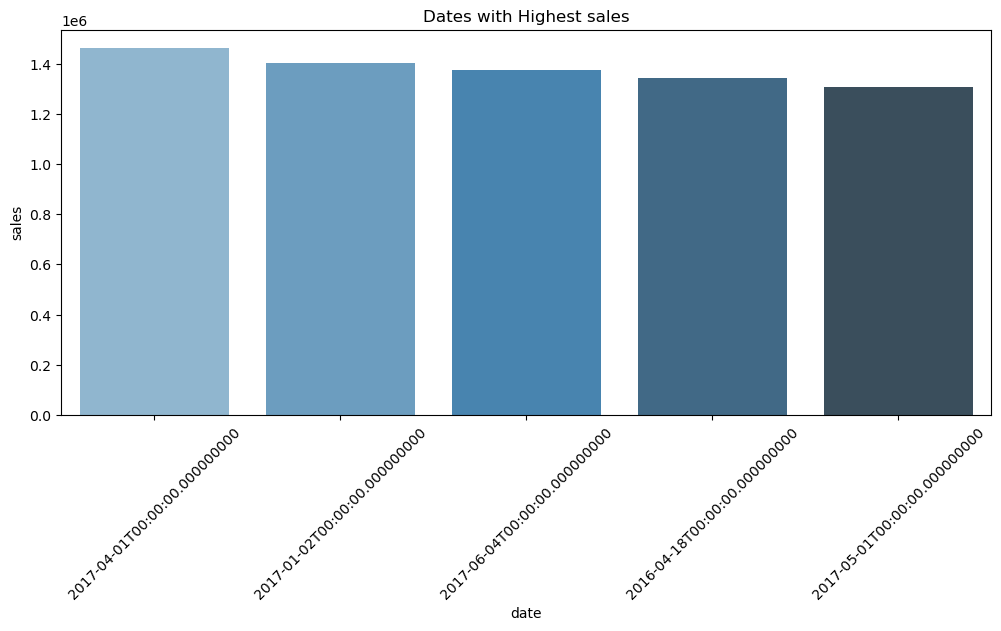

In [207]:
# starting from the top
t = train.groupby("date")["sales"].sum().reset_index().sort_values(by="sales",ascending=False)
fig = plt.figure(figsize=(12,5))
plt.title("Dates with Highest sales")
plt.xticks(rotation=45)
sns.barplot(data=t.iloc[:5] , y="sales", x="date", palette='Blues_d')
fig.show()

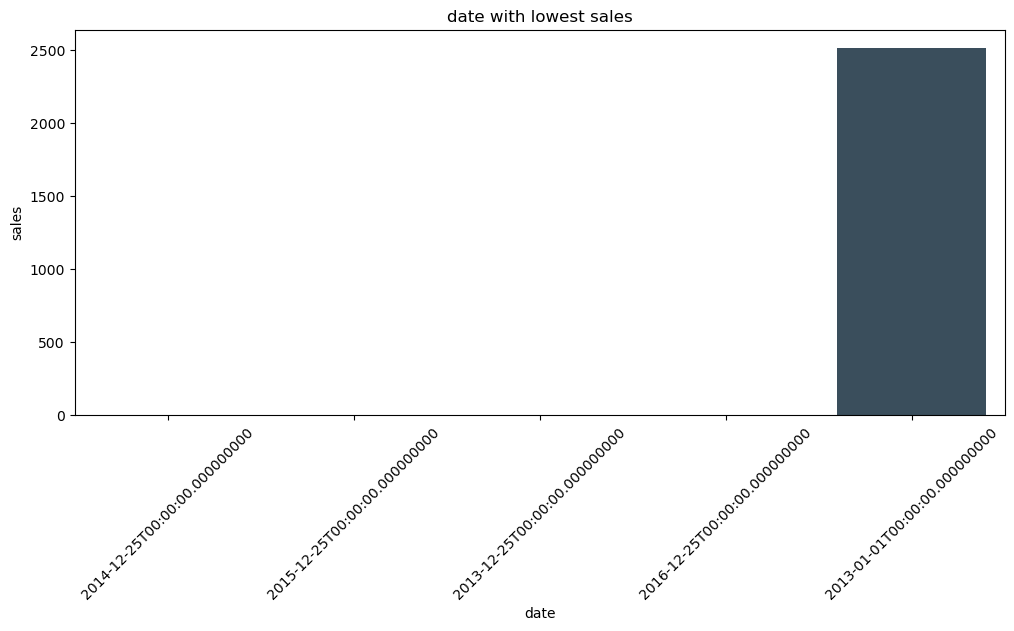

In [208]:
# starting from the bottom
c = train.groupby("date")["sales"].sum().reset_index().sort_values(by="sales",ascending=True)
fig = plt.figure(figsize=(12,5))
plt.title("date with lowest sales")
plt.xticks(rotation=45)
sns.barplot(data=c.iloc[:5] , y="sales", x="date", palette='Blues_d')
fig.show()

### merging our data
we want to merge the transactions with our train data, so we can use it to train our model

In [29]:
train.shape

(3008016, 5)

In [30]:

mer = train.merge(
    stores, 
    how='left', 
    on=['store_nbr'])

# merged=mer.merge(
#     transactions, 
#     how='left', 
#     on=['date', 'store_nbr'])
# merged.head()

In [31]:
#merging merged with oil data
merged2=mer.merge(
    oil,
    how='left', 
    on=['date'])


merged2.head()

,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,oil_price
0,2013-01-01,1,AUTOMOTIVE,0.0,0.0,Quito,Pichincha,D,13,93.14
1,2013-01-01,1,BABY CARE,0.0,0.0,Quito,Pichincha,D,13,93.14
2,2013-01-01,1,BEAUTY,0.0,0.0,Quito,Pichincha,D,13,93.14
3,2013-01-01,1,BEVERAGES,0.0,0.0,Quito,Pichincha,D,13,93.14
4,2013-01-01,1,BOOKS,0.0,0.0,Quito,Pichincha,D,13,93.14


In [32]:
#merging merged2 with holidays
merged3=merged2.merge(holidays,
    how='left', 
    on=['date'])

print(merged3.shape)
merged3.head()

(3061476, 11)


,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,oil_price,type_y
0,2013-01-01,1,AUTOMOTIVE,0.0,0.0,Quito,Pichincha,D,13,93.14,Holiday
1,2013-01-01,1,BABY CARE,0.0,0.0,Quito,Pichincha,D,13,93.14,Holiday
2,2013-01-01,1,BEAUTY,0.0,0.0,Quito,Pichincha,D,13,93.14,Holiday
3,2013-01-01,1,BEVERAGES,0.0,0.0,Quito,Pichincha,D,13,93.14,Holiday
4,2013-01-01,1,BOOKS,0.0,0.0,Quito,Pichincha,D,13,93.14,Holiday


## Univariate Analysis

## 8. What is the trend of sales over time?

In [34]:
## Visualizing sales in train data
plt.figure(figsize=(12,5))
plt.title('Sales over Time')
train['sales'].plot(linewidth = 0.5)

sales in our train data is seasonal. There is no trend

## 9. What is the trend of transactions over time?

In [35]:
# Create figure
fig = go.Figure()

fig.add_trace(
    go.Scatter(x=list(transactions.date), y=list(transactions.transactions)))

# Set title
fig.update_layout(
    title_text="Transactions over Time"
)

# Add range slider
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1m",
                     step="month",
                     stepmode="backward"),
                dict(count=6,
                     label="6m",
                     step="month",
                     stepmode="backward"),
                dict(count=1,
                     label="YTD",
                     step="year",
                     stepmode="todate"),
                dict(count=1,
                     label="1y",
                     step="year",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)

fig.show()

we get a spike in transactions every December 23rd & around May 10th throughout, this shows seasonality, but no trend
### ADF Test

In [36]:
adfuller(train.sales)

Falied to reject Null Hypothesis: Since p-value is 1.85e-29 (<0.05), Series is non-stationary
## KPSS Test

In [37]:
kpss(train.sales)

p-value is 0.01(<0.05) meaning our series is non-stationary

In [38]:
## Visualizing oil prices in oil data
plt.figure(figsize=(12,5))
plt.title('Oil prices over Time')
merged2['oil_price'].plot.area(linewidth = 0.5)

## Bivariate Analysis

## 10. Highest and lowest performing stores in terms of sales

In [39]:
top_stores_sales = (
    mer.groupby("store_nbr")["sales"]
    .sum()
    .reset_index()
    .sort_values(by="sales",ascending=False)
)

top_stores_transactions = (
    mer.groupby("store_nbr")["transactions"]
    .sum()
    .reset_index()
    .sort_values(by="transactions",ascending=False)
)

topSS=top_stores_sales.iloc[:5]
topST=top_stores_transactions.iloc[:5]

In [40]:
#Plotting stores Vs sales and Transactions
fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
fig.suptitle('Top Stores by Sales and Transactions')

# Bulbasaur
sns.barplot(ax=axes[0], x=topSS.store_nbr, y=topSS.sales)
# axes[0].set_title(bulbasaur.name)

# Charmander
sns.barplot(ax=axes[1], x=topST.store_nbr, y=topST.transactions)
# axes[1].set_title(charmander.name)

## 11. Highest performing family of products

In [41]:
top_family_by_sales = (
    mer.groupby("family")["sales"]
    .sum()
    .reset_index()
    .sort_values(by="sales",ascending=False)
)

topFS=top_family_by_sales.iloc[:5]

In [42]:
#Plotting stores Vs sales 
fig = plt.figure(figsize=(10,3))
plt.title("Top Family by sales")
sns.barplot(data=topFS, x='family', y='sales', palette='Blues_d')
fig.show()

sns.set(font_scale = 1)
plt.xticks(rotation=45)

## Issues with the data
1. missing values in our oil data before merging
2. We need some categorical columns for our model
3. The data has a lot of missing values after merging

## How to fix them
1. We leave them for now
2. We have to do some encoding
3. For time series data, we most likely fill with the value closest to it, but overall, we have to be very careful

resampling

In [43]:
# merged3_daily_mean = merged3.resample('D').mean()
# print(merged3_daily_mean.shape)
# merged3_daily_mean.head(3)

In [44]:
# merged3_daily_mean = merged3.drop(["family", 'type', 'description', 'transferred'], axis=1)
# print(merged3_daily_mean.shape)
# merged3_daily_mean.head(3)

# Feature Processing & Engineering

## Group Categories

In [45]:
merged3.family.unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

our family column has too many categories, so we group them

In [46]:
# merged3['family'] = (merged3['family']
# .replace(['GROCERY II', 'GROCERY I', 'EGGS', 'MEATS', 'DAIRY', 'DELI', 'BEVERAGES', 'PREPARED FOODS', 'PRODUCE', 'LIQUOR,WINE,BEER', 'PET SUPPLIES', 'BREAD/BAKERY', 'SEAFOOD'] 
#          , 'groceries')
# .replace(['HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'CLEANING', 'SCHOOL AND OFFICE SUPPLIES', 'BABY CARE', 'BEAUTY','BOOKS','CELEBRATION', 'HOME CARE', 'LADIESWEAR', 'LINGERIE', 'MAGAZINES', 'PERSONAL CARE', 'POULTRY', 'FROZEN FOODS', 'HOME APPLIANCES'] 
#           , 'home_and_kitchen')
# .replace(['HARDWARE', 'PLAYERS AND ELECTRONICS', 'AUTOMOTIVE', 'LAWN AND GARDEN'] 
#          , 'hardware'))


# test['family'] = (test['family']
# .replace(['GROCERY II', 'GROCERY I', 'EGGS', 'MEATS', 'DAIRY', 'DELI', 'BEVERAGES', 'PREPARED FOODS', 'PRODUCE', 'LIQUOR,WINE,BEER', 'PET SUPPLIES', 'BREAD/BAKERY', 'SEAFOOD'] 
#          , 'groceries')
# .replace(['HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'CLEANING', 'SCHOOL AND OFFICE SUPPLIES', 'BABY CARE', 'BEAUTY','BOOKS','CELEBRATION', 'HOME CARE', 'LADIESWEAR', 'LINGERIE', 'MAGAZINES', 'PERSONAL CARE','POULTRY', 'FROZEN FOODS', 'HOME APPLIANCES'] 
#          , 'home_and_kitchen')
# .replace(['HARDWARE', 'PLAYERS AND ELECTRONICS','AUTOMOTIVE', 'LAWN AND GARDEN'] 
#          , 'hardware'))

In [47]:
merged3.family.unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

## Impute Missing Values

first, lets have a quick overview before deciding how to handle missing values

In [48]:
merged3.isnull().sum()

date                 0
store_nbr            0
family               0
sales                0
onpromotion          0
city                 0
state                0
type_x               0
cluster              0
oil_price            0
type_y         2567862
dtype: int64

since non-holidays are work days, let's impute the last column

In [49]:
merged3['type_y'].unique()

array(['Holiday', nan, 'Work Day', 'Additional', 'Event', 'Transfer',
       'Bridge'], dtype=object)

In [50]:
work_days = merged3[merged3['type_y'] == 'Work Day']
print(work_days.nunique())
work_days

date              5
store_nbr        54
family           33
sales          2524
onpromotion      91
city             22
state            16
type_x            5
cluster          17
oil_price         1
type_y            1
dtype: int64


,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,oil_price,type_y
7128,2013-01-05,1,AUTOMOTIVE,5.000,0.0,Quito,Pichincha,D,13,47.26,Work Day
7129,2013-01-05,1,BABY CARE,0.000,0.0,Quito,Pichincha,D,13,47.26,Work Day
7130,2013-01-05,1,BEAUTY,3.000,0.0,Quito,Pichincha,D,13,47.26,Work Day
7131,2013-01-05,1,BEVERAGES,1160.000,0.0,Quito,Pichincha,D,13,47.26,Work Day
7132,2013-01-05,1,BOOKS,0.000,0.0,Quito,Pichincha,D,13,47.26,Work Day
...,...,...,...,...,...,...,...,...,...,...,...
2555379,2016-11-12,9,POULTRY,529.684,1.0,Quito,Pichincha,B,6,47.26,Work Day
2555381,2016-11-12,9,PREPARED FOODS,158.774,2.0,Quito,Pichincha,B,6,47.26,Work Day
2555383,2016-11-12,9,PRODUCE,1618.001,2.0,Quito,Pichincha,B,6,47.26,Work Day
2555385,2016-11-12,9,SCHOOL AND OFFICE SUPPLIES,3.000,0.0,Quito,Pichincha,B,6,47.26,Work Day


In [51]:
# Fill missing holiday rows with work days
imputer = SimpleImputer(missing_values=np.NaN, strategy='constant', fill_value='Work Day')
merged3['type_y'] = imputer.fit_transform(merged3[['type_y']])

In [52]:
merged3.isna().sum()

date           0
store_nbr      0
family         0
sales          0
onpromotion    0
city           0
state          0
type_x         0
cluster        0
oil_price      0
type_y         0
dtype: int64

## New Features Creation

In [53]:
## Use pandas' powerful time-based indexing to analyze data

def getDateFeatures(df):
    
    df['month'] = df['date'].dt.month
    df['day_of_month'] = df['date'].dt.day
    df['day_of_year'] = df['date'].dt.dayofyear
    df['week_of_year'] = df['date'].dt.isocalendar().week
    df['week_of_year'] = df['week_of_year'].astype(float)
    df['day_of_week'] = df['date'].dt.dayofweek
    df['year'] = df['date'].dt.year
    df["is_weekend"] = np.where(df['day_of_week'] > 4, 1, 0)
    df['is_month_start'] = df['date'].dt.is_month_start.astype(int)
    df['is_month_end'] = df['date'].dt.is_month_end.astype(int)
    df['quarter'] = df['date'].dt.quarter
    df['is_quarter_start'] = df['date'].dt.is_quarter_start.astype(int)
    df['is_quarter_end'] = df['date'].dt.is_quarter_end.astype(int)
    df['is_year_start'] = df['date'].dt.is_year_start.astype(int)
    df['is_year_end'] = df['date'].dt.is_year_end.astype(int)

    df['season'] = np.where(df['month'].isin([6,7,8,9]), 1, 0)
    df['pay_day'] = np.where((df['day_of_month']==15) | (df['is_month_end']==1), 1, 0)
    df['earthquake_impact'] = np.where(df['date'].isin(
        pd.date_range(start='2016-04-16', end='2016-12-31', freq='D')), 1, 0)

    return df

merged3 = getDateFeatures(merged3)


let's make the date column the index

In [54]:
merged3=merged3.set_index(['date'])

## Features Encoding & scaling

In [87]:
merged3.head(2)

,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,oil_price,type_y,...,is_month_start,is_month_end,quarter,is_quarter_start,is_quarter_end,is_year_start,is_year_end,season,pay_day,earthquake_impact
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,0,0.0,0.0,18,12,3,12,93.14,3,...,1,0,1,1,0,1,0,0,0,0
2013-01-01,1,1,0.0,0.0,18,12,3,12,93.14,3,...,1,0,1,1,0,1,0,0,0,0


In [56]:
cols = ['family', 'city', 'state', 'cluster', 'type_y', 'type_x']
for col in cols:
  merged3[col] = LabelEncoder().fit_transform(merged3[col])

In [57]:
# encoder = OneHotEncoder()
# #perform one-hot encoding on 'team' column 
# encoder_df = pd.DataFrame(encoder.fit_transform(x[['family','type','transferred']]).toarray())

In [58]:
# #merge one-hot encoded columns back with original DataFrame
# train_prepared = x.reset_index().join(encoder_df).set_index(['date'])

In [141]:
trainn, evall = merged3[30000:], merged3[:30000]

In [142]:
# Split data into parts
x = trainn.drop(['sales'], axis = 1)
y = trainn['sales']

In [143]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()

# x_scaled = scaler.fit_transform(x)
# x = pd.DataFrame(x_scaled)

In [144]:
# Split data into Train Test
X_train, X_test, y_train, y_test = x[200:], x[:200], y[200:], y[:200]

# Machine Learning Modeling 

# Traditional Machine Learning Models

### Linear Regression

In [145]:
from sklearn.linear_model import LinearRegression
lin_model = LinearRegression()
model_lin = lin_model.fit(X_train, y_train)

# Make prediction on X_test
lin_pred = model_lin.predict(X_test)

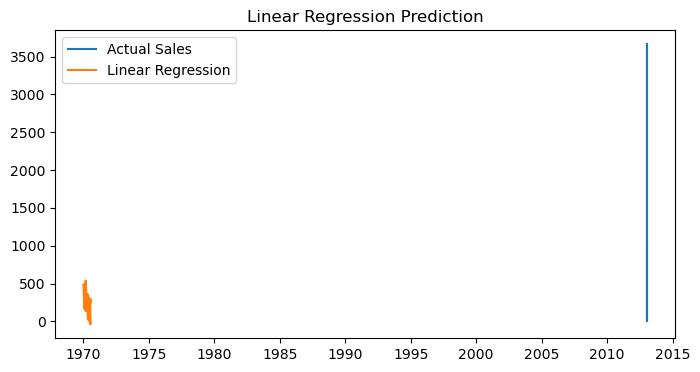

In [146]:
plt.figure(figsize=(8,4))
plt.plot(y_test, label ='Actual Sales')
plt.plot(lin_pred, label='Linear Regression')
plt.legend(loc='best')
plt.title('Linear Regression Prediction')
plt.show()

In [147]:
mse = mean_squared_error(y_test, lin_pred )
#msle = mean_squared_log_error(y_test, lin_pred)
rmse = np.sqrt(mean_squared_error(y_test, lin_pred )).round(2)
#rmsle = np.sqrt(mean_squared_log_error(y_test, lin_pred)).round(2)

results = pd.DataFrame([['Linear', mse, rmse]], columns = ['Model', 'MSE', 'RMSE'])
# results = pd.DataFrame([['AR', mse, msle, rmse, rmsle]], columns = ['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])
# results = results.append(model_results, ignore_index = True)
results

,Model,MSE,RMSE
0,Linear,229300.095693,478.85


### DecisionTreeRegressor

In [148]:
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor()
model_tree = tree.fit(X_train, y_train)

# Make prediction on X_test
tree_pred = model_tree.predict(X_test)

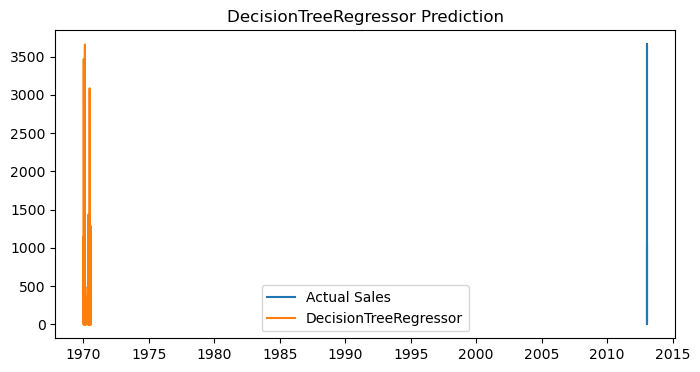

In [149]:
plt.figure(figsize=(8,4))
plt.plot(y_test, label ='Actual Sales')
plt.plot(tree_pred, label='DecisionTreeRegressor')
plt.legend(loc='best')
plt.title('DecisionTreeRegressor Prediction')
plt.show()

In [150]:
mse = mean_squared_error(y_test, tree_pred )
rmse = np.sqrt(mean_squared_error(y_test, tree_pred )).round(2)
rmsle = np.sqrt(mean_squared_log_error(y_test, tree_pred)).round(2)
msle = mean_squared_log_error(y_test, tree_pred).round(2)


# model_results = pd.DataFrame([['DecisionTree', mse, rmse]], columns = ['Model', 'MSE', 'RMSE'])
model_results = pd.DataFrame([['DecisionTree', mse, msle, rmse, rmsle]], columns = ['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])
results = results.append(model_results, ignore_index = True)
results

,Model,MSE,RMSE,MSLE,RMSLE
0,Linear,229300.095693,478.85,NaN,NaN
1,DecisionTree,5448.724649,73.82,0.07,0.27


### xgboost

In [151]:
from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor
# fit model no training data
boost = XGBRegressor()
boost.fit(X_train, y_train)

# make predictions for test data
boost_pred = boost.predict(X_test)

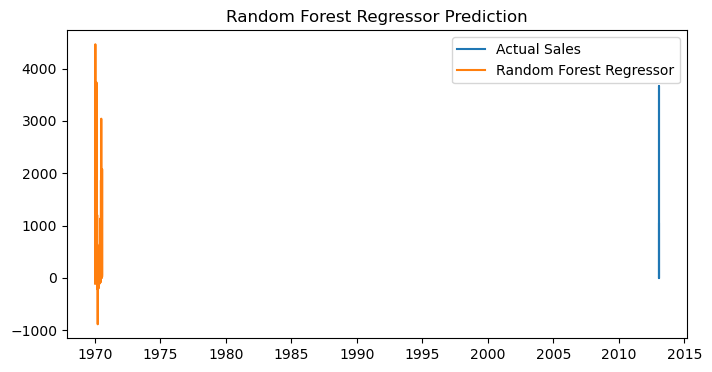

In [152]:
plt.figure(figsize=(8,4))
plt.plot(y_test, label ='Actual Sales')
plt.plot(boost_pred, label='Random Forest Regressor')
plt.legend(loc='best')
plt.title('Random Forest Regressor Prediction')
plt.show()

In [153]:
mse = mean_squared_error(y_test, boost_pred )
# msle = mean_squared_log_error(y_test, boost_pred)
rmse = np.sqrt(mean_squared_error(y_test, boost_pred )).round(2)
# rmsle = np.sqrt(mean_squared_log_error(y_test, boost_pred)).round(2)

model_results = pd.DataFrame([['xgBoost', mse, rmse]], columns = ['Model', 'MSE', 'RMSE'])
# model_results = pd.DataFrame([['xgBoost', mse, msle, rmse, rmsle]], columns = ['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])
results = results.append(model_results, ignore_index = True)
results

,Model,MSE,RMSE,MSLE,RMSLE
0,Linear,229300.095693,478.85,NaN,NaN
1,DecisionTree,5448.724649,73.82,0.07,0.27
2,xgBoost,37462.470684,193.55,NaN,NaN


### light gbm

In [154]:
from lightgbm import LGBMRegressor
# fit model no training data
model_lgbm = LGBMRegressor()
model_lgbm.fit(X_train, y_train)

# make predictions for test data
lgbm_pred = model_lgbm.predict(X_test)

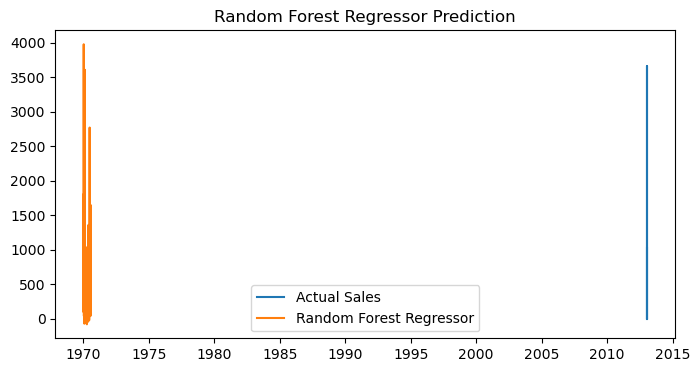

In [155]:
plt.figure(figsize=(8,4))
plt.plot(y_test, label ='Actual Sales')
plt.plot(lgbm_pred, label='Random Forest Regressor')
plt.legend(loc='best')
plt.title('Random Forest Regressor Prediction')
plt.show()

In [156]:
mse = mean_squared_error(y_test, lgbm_pred )
# msle = mean_squared_log_error(y_test, lgbm_pred)
rmse = np.sqrt(mean_squared_error(y_test, lgbm_pred )).round(2)
# rmsle = np.sqrt(mean_squared_log_error(y_test, lgbm_pred)).round(2)

model_results = pd.DataFrame([['lightGBM', mse, rmse]], columns = ['Model', 'MSE', 'RMSE'])
# model_results = pd.DataFrame([['Light_gbm', mse, msle, rmse, rmsle]], columns = ['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])
results = results.append(model_results, ignore_index = True)
results

,Model,MSE,RMSE,MSLE,RMSLE
0,Linear,229300.095693,478.85,NaN,NaN
1,DecisionTree,5448.724649,73.82,0.07,0.27
2,xgBoost,37462.470684,193.55,NaN,NaN
3,lightGBM,25211.501730,158.78,NaN,NaN


### KNN

In [157]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=1)
# fit model no training data
neigh.fit(X_train, y_train)

# make predictions for test data
neigh_pred = neigh.predict(X_test)

In [158]:
mse = mean_squared_error(y_test, neigh_pred )
msle = mean_squared_log_error(y_test, neigh_pred)
rmse = np.sqrt(mean_squared_error(y_test, neigh_pred )).round(2)
rmsle = np.sqrt(mean_squared_log_error(y_test, neigh_pred)).round(5)

# model_results = pd.DataFrame([['lightGBM', mse, rmse]], columns = ['Model', 'MSE', 'RMSE'])
model_results = pd.DataFrame([['KNN', mse, msle, rmse, rmsle]], columns = ['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])
results = results.append(model_results, ignore_index = True)
results

,Model,MSE,RMSE,MSLE,RMSLE
0,Linear,229300.095693,478.85,NaN,NaN
1,DecisionTree,5448.724649,73.82,0.070000,0.27000
2,xgBoost,37462.470684,193.55,NaN,NaN
3,lightGBM,25211.501730,158.78,NaN,NaN
4,KNN,2628.070195,51.26,0.293239,0.54152


In [159]:
rmse_val = [] #to store rmse values for different k
for K in range(10):
    K = K+1
    model = KNeighborsRegressor(n_neighbors=K)

    model.fit(X_train, y_train)  #fit the model
    pred=model.predict(X_test) #make prediction on test set
    error = np.sqrt(mean_squared_log_error(y_test,pred)).round(5) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSLE value for k= ' , K , 'is:', error)

RMSLE value for k=  1 is: 0.54152
RMSLE value for k=  2 is: 1.75647
RMSLE value for k=  3 is: 2.1287
RMSLE value for k=  4 is: 2.2435
RMSLE value for k=  5 is: 2.47352
RMSLE value for k=  6 is: 2.64744
RMSLE value for k=  7 is: 2.62312
RMSLE value for k=  8 is: 2.76129
RMSLE value for k=  9 is: 2.79923
RMSLE value for k=  10 is: 2.8388


### SGDRegressor

In [160]:
from sklearn.linear_model import SGDRegressor
SGDReg = SGDRegressor(max_iter=5, tol=1e-3)
# fit model no training data
SGDReg.fit(X_train, y_train)

# make predictions for test data
SGDReg_pred = SGDReg.predict(X_test)

In [161]:
mse = mean_squared_error(y_test, SGDReg_pred )
# msle = mean_squared_log_error(y_test, SGDReg_pred)
rmse = np.sqrt(mean_squared_error(y_test, SGDReg_pred )).round(2)
# rmsle = np.sqrt(mean_squared_log_error(y_test, SGDReg_pred)).round(2)

model_results = pd.DataFrame([['lightGBM', mse, rmse]], columns = ['Model', 'MSE', 'RMSE'])
# model_results = pd.DataFrame([['SGDReg', mse, msle, rmse, rmsle]], columns = ['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])/
results = results.append(model_results, ignore_index = True)
results

,Model,MSE,RMSE,MSLE,RMSLE
0,Linear,2.293001e+05,4.788500e+02,NaN,NaN
1,DecisionTree,5.448725e+03,7.382000e+01,0.070000,0.27000
2,xgBoost,3.746247e+04,1.935500e+02,NaN,NaN
3,lightGBM,2.521150e+04,1.587800e+02,NaN,NaN
4,KNN,2.628070e+03,5.126000e+01,0.293239,0.54152
5,lightGBM,5.708718e+28,2.389292e+14,NaN,NaN


## BackTest

In [169]:
backtests = {
    1: ('2017-07-01', '2017-07-15'),
    2: ('2017-07-15', '2017-07-30'),
    3: ('2017-08-01', '2017-08-15')
}

In [162]:
# Backtests with Decision Tree
scores = {}

for idx, period in enumerate(backtests):
    
    _train = merged3.reset_index()[merged3.reset_index()['date'] < backtests[period][0]]
    _test = merged3.reset_index()[(merged3.reset_index()['date'] >= backtests[period][0]) & (merged3.reset_index()['date'] <= backtests[period][1])]
    
    Xtrain, ytrain = _train.set_index(['date']).drop(columns=['sales']).values, _train.sales.values
    Xtest, ytest = _test.set_index(['date']).drop(columns=['sales']).values, _test.sales.values
    
    lgbm_model = model_tree.fit(Xtrain, ytrain)
    
    ypred = lgbm_model.predict(Xtest)
    
    scores[period] = np.sqrt(mean_squared_log_error(ytest, ypred))

print(scores)

{1: 0.5769399295736737, 2: 0.5777455461709767, 3: 0.5972513777601507}


## trying our validation set (overfitting or underfitting)

In [171]:
# Split data into parts
x = evall.drop(['sales'], axis = 1)
y = evall['sales']

In [172]:
# Split data into Train Test
X_train, X_test, y_train, y_test = x[43:], x[:43], y[43:], y[:43]

In [173]:
model_tree = tree.fit(X_train, y_train)

# Make prediction on X_test
tree_pred = model_tree.predict(X_test)

In [174]:
mse = mean_squared_error(y_test, tree_pred )
rmse = np.sqrt(mean_squared_error(y_test, tree_pred )).round(2)
rmsle = np.sqrt(mean_squared_log_error(y_test, tree_pred)).round(2)
msle = mean_squared_log_error(y_test, tree_pred).round(2)


results = pd.DataFrame([['DecisionTree', mse, msle, rmse, rmsle]], columns = ['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])
results

,Model,MSE,MSLE,RMSE,RMSLE
0,DecisionTree,4414.581395,1.96,66.44,1.4


In [175]:
# fit model no training data
neigh.fit(X_train, y_train)

# make predictions for test data
neigh_pred = neigh.predict(X_test)

In [176]:
mse = mean_squared_error(y_test, neigh_pred )
msle = mean_squared_log_error(y_test, neigh_pred)
rmse = np.sqrt(mean_squared_error(y_test, neigh_pred )).round(2)
rmsle = np.sqrt(mean_squared_log_error(y_test, neigh_pred)).round(5)

model_results = pd.DataFrame([['KNN', mse, msle, rmse, rmsle]], columns = ['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])
results = results.append(model_results, ignore_index = True)
results

,Model,MSE,MSLE,RMSE,RMSLE
0,DecisionTree,4414.581395,1.960000,66.44,1.40000
1,KNN,4178.186047,1.552448,64.64,1.24597


our models underfits the validation set with RMSLE but...

RMSE score gives a better fit for DecisionTree

## Preparing our test data

In [177]:
test

,date,store_nbr,family,onpromotion
0,2017-08-16,1,AUTOMOTIVE,0
1,2017-08-16,1,BABY CARE,0
2,2017-08-16,1,BEAUTY,2
3,2017-08-16,1,BEVERAGES,20
4,2017-08-16,1,BOOKS,0
...,...,...,...,...
28507,2017-08-31,9,POULTRY,1
28508,2017-08-31,9,PREPARED FOODS,0
28509,2017-08-31,9,PRODUCE,1
28510,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9


for our test data, we merge just like for our train data

In [182]:
merT = test.merge(stores, how='left', on=['store_nbr'])
merged2T=merT.merge(oil,how='left', on=['date'])
merged3_test=merged2T.merge(holidays,how='left', on=['date'])

missing values

In [183]:
merged3_test.isna().sum()

date               0
store_nbr          0
family             0
onpromotion        0
city               0
state              0
type_x             0
cluster            0
oil_price          0
type_y         26730
dtype: int64

In [184]:
# Fill missing holiday rows with normal days
imputer = SimpleImputer(missing_values=np.NaN, strategy='constant', fill_value='Work Day')
merged3_test['type_y'] = imputer.fit_transform(merged3_test[['type_y']])

In [187]:
merged3_test.isna().sum()

date           0
store_nbr      0
family         0
onpromotion    0
city           0
state          0
type_x         0
cluster        0
oil_price      0
type_y         0
dtype: int64

features engineering

In [189]:
def getDateFeatures(df):
    
    df['month'] = df['date'].dt.month
    df['day_of_month'] = df['date'].dt.day
    df['day_of_year'] = df['date'].dt.dayofyear
    df['week_of_year'] = df['date'].dt.isocalendar().week
    df['week_of_year'] = df['week_of_year'].astype(float)
    df['day_of_week'] = df['date'].dt.dayofweek
    df['year'] = df['date'].dt.year
    df["is_weekend"] = np.where(df['day_of_week'] > 4, 1, 0)
    df['is_month_start'] = df['date'].dt.is_month_start.astype(int)
    df['is_month_end'] = df['date'].dt.is_month_end.astype(int)
    df['quarter'] = df['date'].dt.quarter
    df['is_quarter_start'] = df['date'].dt.is_quarter_start.astype(int)
    df['is_quarter_end'] = df['date'].dt.is_quarter_end.astype(int)
    df['is_year_start'] = df['date'].dt.is_year_start.astype(int)
    df['is_year_end'] = df['date'].dt.is_year_end.astype(int)

    df['season'] = np.where(df['month'].isin([6,7,8,9]), 1, 0)
    df['pay_day'] = np.where((df['day_of_month']==15) | (df['is_month_end']==1), 1, 0)
    df['earthquake_impact'] = np.where(df['date'].isin(
        pd.date_range(start='2016-04-16', end='2016-12-31', freq='D')), 1, 0)

    return df

merged3_test = getDateFeatures(merged3_test).set_index(['date'])

In [190]:
cols = ['family', 'city', 'state', 'cluster', 'type_y', 'type_x']
for col in cols:
  merged3_test[col] = LabelEncoder().fit_transform(merged3_test[col])

In [191]:
merged3_test

,store_nbr,family,onpromotion,city,state,type_x,cluster,oil_price,type_y,month,...,is_month_start,is_month_end,quarter,is_quarter_start,is_quarter_end,is_year_start,is_year_end,season,pay_day,earthquake_impact
date,,,,,,,,,,,,,,,,,,,,,
2017-08-16,1,0,0,18,12,3,12,46.80,1,8,...,0,0,3,0,0,0,0,1,0,0
2017-08-16,1,1,0,18,12,3,12,46.80,1,8,...,0,0,3,0,0,0,0,1,0,0
2017-08-16,1,2,2,18,12,3,12,46.80,1,8,...,0,0,3,0,0,0,0,1,0,0
2017-08-16,1,3,20,18,12,3,12,46.80,1,8,...,0,0,3,0,0,0,0,1,0,0
2017-08-16,1,4,0,18,12,3,12,46.80,1,8,...,0,0,3,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-31,9,28,1,18,12,1,5,47.26,1,8,...,0,1,3,0,0,0,0,1,1,0
2017-08-31,9,29,0,18,12,1,5,47.26,1,8,...,0,1,3,0,0,0,0,1,1,0
2017-08-31,9,30,1,18,12,1,5,47.26,1,8,...,0,1,3,0,0,0,0,1,1,0


### predicting sales in our test

In [193]:
test_pred = model_tree.predict(merged3_test)

In [206]:
test_sales = pd.DataFrame(test_pred, columns=['sales'])
test_sales.head(30)

,sales
0,1.000
1,0.000
2,0.000
3,0.000
4,0.000
5,386.158
6,0.000
7,980.000
8,530.000
9,147.149


In [ ]:
# Save sample submission
# test_sales[[ 'sales']].to_csv('submission.csv', index=False)